## Cape Cod - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Cape Cod

#### Install and import the required libraries

In [1]:
import sys
#! python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

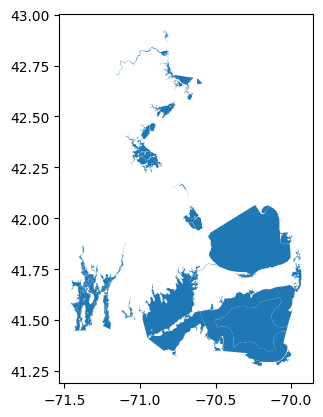

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url)  # Already 4326 standard
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(11286, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 42.677389
LongitudeMeasure                               -71.421056
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:356: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  cond_notna = mask & (df_out["QA_flag"].notna())  # Mask cond and not NA
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(11286, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits'}

<Axes: >

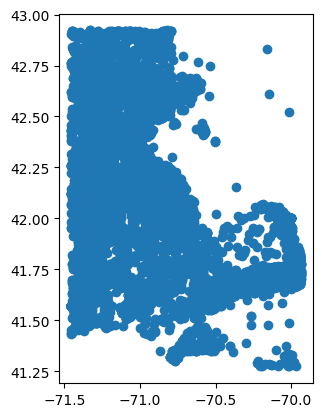

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

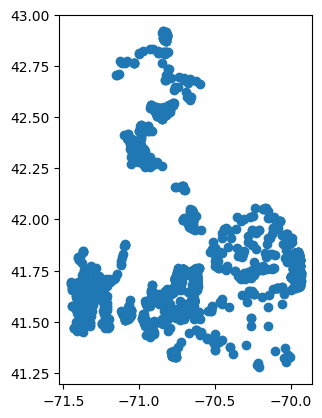

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

1880

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path,'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/dataretrieval/wqp.py:153: DtypeWarning: Columns (8,10,13,15,17,19,20,21,22,23,28,31,33,34,36,38,60,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,BRC,Blackstone River Coalition (Volunteer),BRC-C-02-02-020:20131012040800:FM:0.2083333333...,2013-10-12,04:08:00,EST,BRC-C-02-02-020,STORET-1039097035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,OARS,OARS - For the Assabet Sudbury & Concord River...,OARS-CND-161:20130818:0651:FM:1,2013-08-18,06:51:00,EDT,OARS-CND-161,STORET-838568413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,OARS,OARS - For the Assabet Sudbury & Concord River...,OARS-SUD-064:20130721:0610:FM:1,2013-07-21,06:10:00,EDT,OARS-SUD-064,STORET-838568309,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,130809111433.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-m41:20131017:FM:B,2013-10-17,NaN,NaN,WTGHA-M41,STORET-1041401688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569749,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_DUCK_W_19560816_731708,1956-08-16,NaN,NaN,11NPSWRD_WQX-CACO_DUCK_W,STORET-740598866,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
569750,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_DUCK_W_19560616_731704,1956-06-16,NaN,NaN,11NPSWRD_WQX-CACO_DUCK_W,STORET-740598862,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
569751,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_DUCK_W_19560701_731705,1956-07-01,NaN,NaN,11NPSWRD_WQX-CACO_DUCK_W,STORET-740598863,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
569752,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_GREAT_W_19550816_731703,1955-08-16,NaN,NaN,11NPSWRD_WQX-CACO_GREAT_W,STORET-740649462,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET


<Axes: >

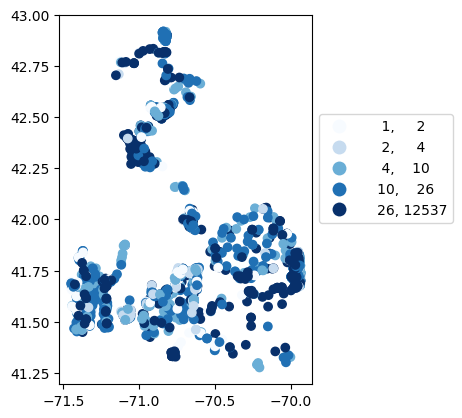

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ResultMeasureValue: missing (NaN) result' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: '%' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(3.25, 'meter')> <Quantity(4.25, 'meter')>
 <Quantity(3.5, 'meter')> ... <Quantity(17.0, 'meter')>
 <Quantity(16.0, 'meter')> <Quantity(7.8, 'meter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    8961.000000
mean       -5.920774
std       298.744632
min     -9999.000000
25%         1.400000
50%         2.000000
75%         3.962400
max        27.000000
dtype: float64
Unusable results: 2134
Usable results with inferred units: 8
Results outside threshold (0.0 to 1786.54702135132): 16


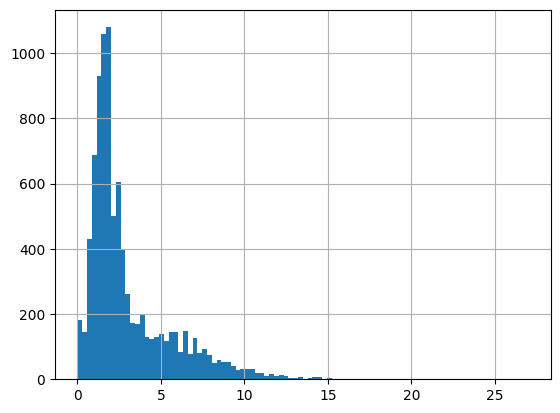

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, "Depth, Secchi disk depth", errors="ignore", intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
48,11113300-GRTKINSD,3.25,m,NaN,m,3.25 meter
179,11113300-BEADERD,4.25,m,NaN,m,4.25 meter
317,11113300-ANGSDND,3.5,m,NaN,m,3.5 meter
698,11113300-GRTKINSD,2.25,m,NaN,m,2.25 meter
740,11113300-GRTKINSD,4.75,m,NaN,m,4.75 meter
...,...,...,...,...,...,...
569749,11NPSWRD_WQX-CACO_DUCK_W,10.0,m,NaN,m,10.0 meter
569750,11NPSWRD_WQX-CACO_DUCK_W,17.0,m,NaN,m,17.0 meter
569751,11NPSWRD_WQX-CACO_DUCK_W,16.0,m,NaN,m,16.0 meter
569752,11NPSWRD_WQX-CACO_GREAT_W,7.8,m,NaN,m,7.8 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
25127,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
38414,11113300-ISLDERD,=4.25,m,"ResultMeasureValue: ""=4.25"" result cannot be used",m,NaN
38813,11113300-ROBHUDD,=2.25,m,"ResultMeasureValue: ""=2.25"" result cannot be used",m,NaN
39063,11113300-ROBHUDD,=3,m,"ResultMeasureValue: ""=3"" result cannot be used",m,NaN
39483,11113300-LONDVLD,=2.675,m,"ResultMeasureValue: ""=2.675"" result cannot be ...",m,NaN
...,...,...,...,...,...,...
486665,11113300-DARLITD,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
493734,11113300-WORSALD,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
496626,11113300-DARLITD,=1.1,m,"ResultMeasureValue: ""=1.1"" result cannot be used",m,NaN
496662,11113300-DARLITD,=1.5,m,"ResultMeasureValue: ""=1.5"" result cannot be used",m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
25127,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
38414,11113300-ISLDERD,=4.25,m,"ResultMeasureValue: ""=4.25"" result cannot be used",m,NaN
38813,11113300-ROBHUDD,=2.25,m,"ResultMeasureValue: ""=2.25"" result cannot be used",m,NaN
39063,11113300-ROBHUDD,=3,m,"ResultMeasureValue: ""=3"" result cannot be used",m,NaN
39483,11113300-LONDVLD,=2.675,m,"ResultMeasureValue: ""=2.675"" result cannot be ...",m,NaN
...,...,...,...,...,...,...
486665,11113300-DARLITD,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
493734,11113300-WORSALD,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
496626,11113300-DARLITD,=1.1,m,"ResultMeasureValue: ""=1.1"" result cannot be used",m,NaN
496662,11113300-DARLITD,=1.5,m,"ResultMeasureValue: ""=1.5"" result cannot be used",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,45,3.765500
1,11113300-ARLSALD,3,3.400000
2,11113300-BARKIND,1,2.100000
3,11113300-BAYKIND,1,1.900000
4,11113300-BEADERD,46,3.666304
...,...,...,...
987,WWMD_VA-SH1,2,1.500000
988,WWMD_VA-SH2,2,1.800000
989,WWMD_VA-SR6A,1,0.500000
990,WWMD_VA-WF2,1,0.600000


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

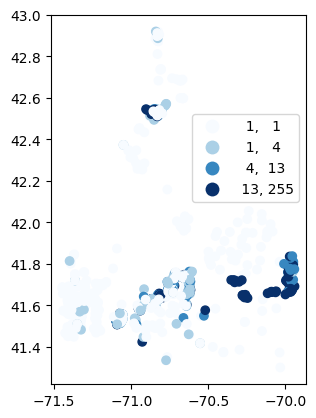

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

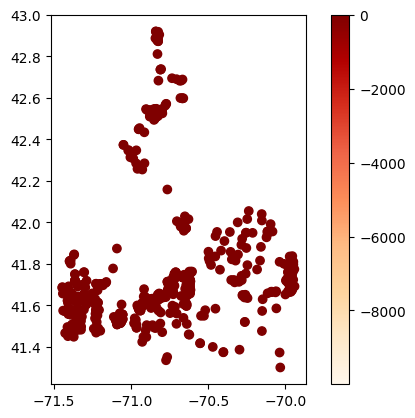

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(22.18, 'degree_Celsius')> <Quantity(23.01, 'degree_Celsius')>
 <Quantity(17.39, 'degree_Celsius')> ... <Quantity(4.0, 'degree_Celsius')>
 <Quantity(1.5, 'degree_Celsius')> <Quantity(3.9, 'degree_Celsius')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    149034.000000
mean         16.297632
std           7.273565
min          -9.830000
25%          11.208250
50%          17.290000
75%          21.900000
max         910.000000
dtype: float64
Unusable results: 214
Usable results with inferred units: 217
Results outside threshold (0.0 to 59.9390239067705): 467


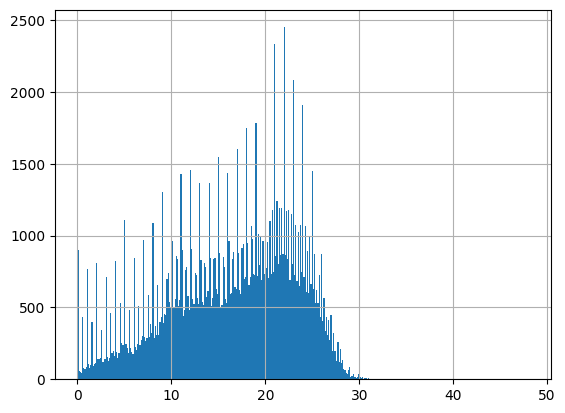

In [32]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
1,OARS-CND-161,22.18,deg C,NaN,22.18 degree_Celsius,degC
3,CRWA-ROB,23.01,deg C,NaN,23.01 degree_Celsius,degC
5,WTGHA-M43,17.39,deg C,NaN,17.39 degree_Celsius,degC
8,MASSDEP-W2386,20.9,deg C,NaN,20.9 degree_Celsius,degC
12,WTGHA-S35,22.54,deg C,NaN,22.54 degree_Celsius,degC
...,...,...,...,...,...,...
569734,11NPSWRD_WQX-CACO_GULL,4.8,deg C,NaN,4.8 degree_Celsius,degC
569735,11NPSWRD_WQX-CACO_GULL,9.1,deg C,NaN,9.1 degree_Celsius,degC
569736,11NPSWRD_WQX-CACO_GULL,4.0,deg C,NaN,4.0 degree_Celsius,degC
569737,11NPSWRD_WQX-CACO_GULL,1.5,deg C,NaN,1.5 degree_Celsius,degC


In [34]:
# Examine deg F
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'] == 'deg F']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
12632,NALMS-F865245,81,deg F,NaN,27.222222222222285 degree_Celsius,degF
31004,11113300-HOODERD,59.2,deg F,NaN,15.111111111111143 degree_Celsius,degF
31375,11113300-HOODERD,59.1,deg F,NaN,15.0555555555556 degree_Celsius,degF
31705,11113300-HOODERD,59.9,deg F,NaN,15.500000000000057 degree_Celsius,degF
32253,11113300-HOODERD,56,deg F,NaN,13.333333333333371 degree_Celsius,degF
...,...,...,...,...,...,...
565862,11NPSWRD_WQX-SAIR_DMF11_HS1,56.0,deg F,NaN,13.333333333333371 degree_Celsius,degF
565863,11NPSWRD_WQX-SAIR_DMF11_OS3,62.0,deg F,NaN,16.666666666666686 degree_Celsius,degF
565864,11NPSWRD_WQX-SAIR_DMF11_OS4,61.0,deg F,NaN,16.111111111111143 degree_Celsius,degF
565870,11NPSWRD_WQX-SAIR_DMF11_S2,43.0,deg F,NaN,6.111111111111143 degree_Celsius,degF


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
177453,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
177454,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
177455,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
177456,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
177457,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...,...
178790,AQUINNAH-SQUIB # 33,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
178791,AQUINNAH-SQUIB # 33,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
178947,AQUINNAH-SQUIB # 33,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
245324,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
361,MERRIMACK_RIVER_WATERSHED_WQX-Hayden-Schofield,8,count,NaN,NaN,count
3668,MERRIMACK_RIVER_WATERSHED_WQX-Manchester,8,count,NaN,NaN,count
4193,MERRIMACK_RIVER_WATERSHED_WQX-Nina-Scarito,8,count,NaN,NaN,count
5321,MERRIMACK_RIVER_WATERSHED_WQX-Misserville,8,count,NaN,NaN,count
5731,MERRIMACK_RIVER_WATERSHED_WQX-Ferrous,8,count,NaN,NaN,count
...,...,...,...,...,...,...
385996,11NPSWRD_WQX-SAIR_SWC_SR3,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
393664,11NPSWRD_WQX-SAIR_SWC_SR6,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
395152,11NPSWRD_WQX-SAIR_SWC_SR7,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
400114,11NPSWRD_WQX-SAIR_SWC_SRT9,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
6492,WWMD_VA-WWE1149PI,1,18.800000
6493,WWMD_VA-WWE1150PI,1,21.300000
6494,WWMD_VA-WWE1151PI,2,20.700000
6495,WWMD_VA-WWE1152PI,1,20.000000


<Axes: >

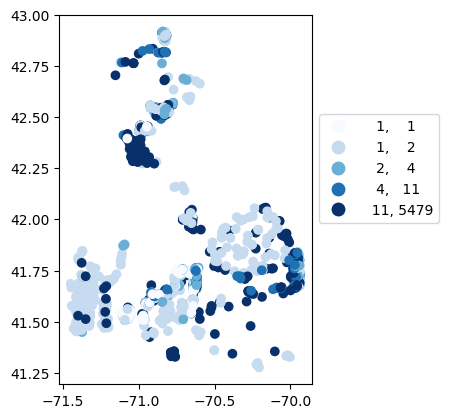

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

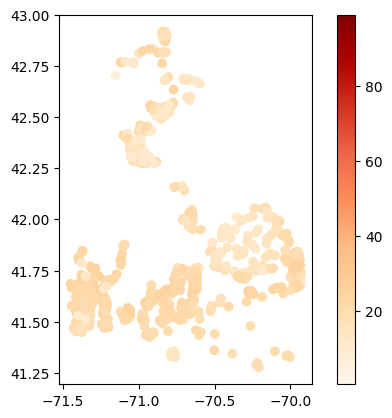

In [40]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(4.6, 'milligram / liter')> <Quantity(9.4, 'milligram / liter')>
 <Quantity(10.3, 'milligram / liter')> ...
 <Quantity(7.7, 'milligram / liter')>
 <Quantity(8.51, 'milligram / liter')>
 <Quantity(6.01, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
14,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
17,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
19,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
22,WTGHA-M46,24.7,mg/L,NaN,24.7 milligram / liter
23,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
...,...,...,...,...,...
569444,HORSLEYWITTEN_WQX-BWB2A,3.76,mg/L,NaN,3.76 milligram / liter
569446,HORSLEYWITTEN_WQX-B3,7.57,mg/L,NaN,7.57 milligram / liter
569455,HORSLEYWITTEN_WQX-BWB2A,7.7,mg/L,NaN,7.7 milligram / liter
569463,HORSLEYWITTEN_WQX-BWB4,8.51,mg/L,NaN,8.51 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
14,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
17,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
19,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
22,WTGHA-M46,24.7,mg/L,NaN,24.7 milligram / liter
23,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
...,...,...,...,...,...
569444,HORSLEYWITTEN_WQX-BWB2A,3.76,mg/L,NaN,3.76 milligram / liter
569446,HORSLEYWITTEN_WQX-B3,7.57,mg/L,NaN,7.57 milligram / liter
569455,HORSLEYWITTEN_WQX-BWB2A,7.7,mg/L,NaN,7.7 milligram / liter
569463,HORSLEYWITTEN_WQX-BWB4,8.51,mg/L,NaN,8.51 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
2808,WWMD_VA-SR5,1,10.810000
2809,WWMD_VA-WF2,2,6.800000
2810,WWMD_VA-WI1,1,9.510000
2811,WWMD_VA-WR2X,2,6.000000


<Axes: >

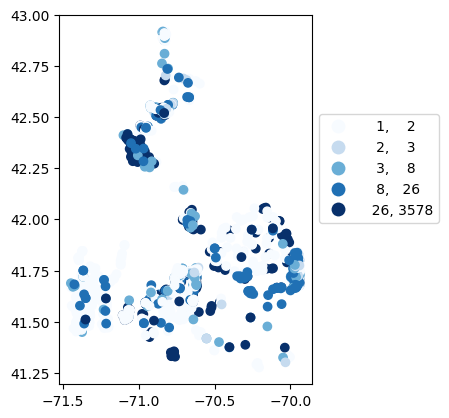

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

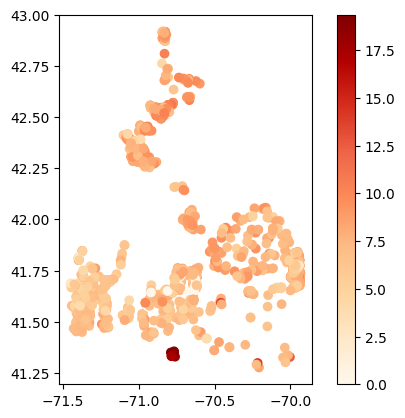

In [46]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'mV' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(7.3, 'dimensionless')> <Quantity(8.16, 'dimensionless')>
 <Quantity(7.99, 'dimensionless')> ... <Quantity(6.6, 'dimensionless')>
 <Quantity(6.8, 'dimensionless')> <Quantity(7.1, 'dimensionless')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    107499.000000
mean          6.682892
std           4.086413
min          -3.124705
25%           5.860000
50%           6.800000
75%           7.680000
max         788.000000
dtype: float64
Unusable results: 4532
Usable results with inferred units: 85945
Results outside threshold (0.0 to 31.201372009432312): 14


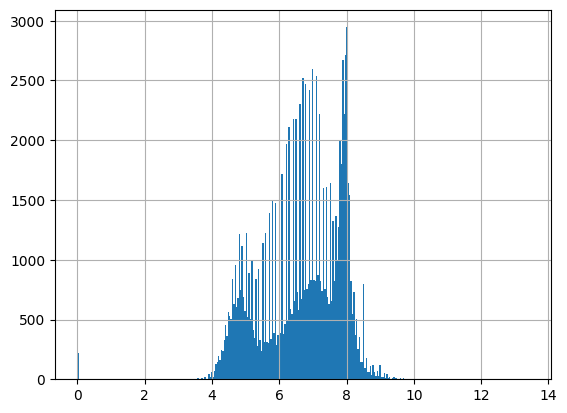

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, "pH", errors="ignore", report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
6,7.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.3 dimensionless
9,8.16,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.16 dimensionless
26,7.99,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.99 dimensionless
43,6.61,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.61 dimensionless
45,8.23,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.23 dimensionless
...,...,...,...,...
569646,6.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.6 dimensionless
569653,6.9,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.9 dimensionless
569677,6.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.6 dimensionless
569692,6.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.8 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/basis.py:154: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn(f"Mismatched {flag}", UserWarning)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'deg C' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(30.33, 'Practical_Salinity_Units')>
 <Quantity(30.48, 'Practical_Salinity_Units')>
 <Quantity(33.3, 'Practical_Salinity_Units')> ...
 <Quantity(0.09, 'Practical_Salinity_Units')>
 <Quantity(0.09, 'Practical_Salinity_Units')>
 <Quantity(0.04, 'Practical_Salinity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    59993.000000
mean        23.314974
std         20.608904
min        -30.000000
25%         13.480000
50%         30.000000
75%         31.500000
max       4003.482834
dtype: float64
Unusable results: 219
Usable results with inferred units: 1
Results outside threshold (0.0 to 146.96839815303014): 3


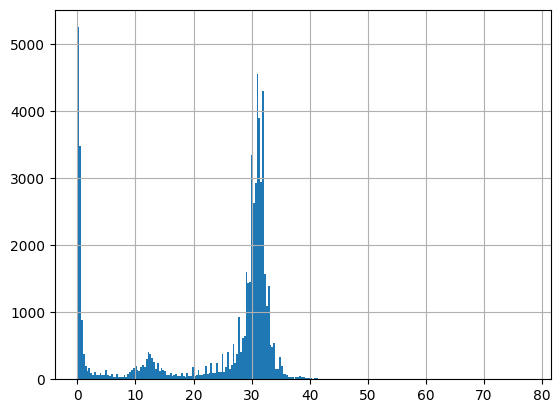

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
10,30.33,ppt,NaN,30.33 Practical_Salinity_Units
51,30.48,ppt,NaN,30.48 Practical_Salinity_Units
56,33.3,ppth,NaN,33.3 Practical_Salinity_Units
73,30.91,ppt,NaN,30.91 Practical_Salinity_Units
77,0.21,ppth,NaN,0.21 Practical_Salinity_Units
...,...,...,...,...
569426,0.05,ppt,NaN,0.05 Practical_Salinity_Units
569432,0.1,ppt,NaN,0.1 Practical_Salinity_Units
569448,0.09,ppt,NaN,0.09 Practical_Salinity_Units
569451,0.09,ppt,NaN,0.09 Practical_Salinity_Units


##### Nitrogen

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'as N' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:484: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['as N' 'as N' 'as N' ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df[c_mask] = basis.basis_from_method_spec(self.df[c_mask])


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/pandas/core/construction.py:627: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/pandas/core/construction.py:627: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.926976, 'milligram / liter')>
 <Quantity(1.571196, 'milligram / liter')>
 <Quantity(0.816144, 'milligram / liter')> ...
 <Quantity(0.238, 'milligram / liter')>
 <Quantity(0.052, 'milligram / liter')>
 <Quantity(0.119, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtyp

-Usable results-
count    2459.000000
mean        6.364974
std       105.839795
min         0.000800
25%         0.075500
50%         0.250000
75%         1.013360
max      2800.000000
dtype: float64
Unusable results: 243
Usable results with inferred units: 0
Results outside threshold (0.0 to 641.4037445624855): 6


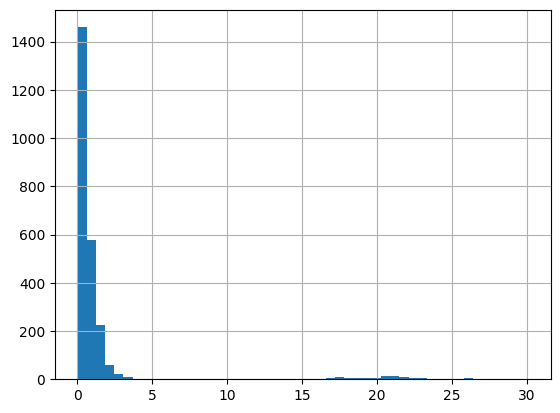

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
877,0.926976,mg/L,NaN,0.926976 milligram / liter
953,1.571196,mg/L,NaN,1.571196 milligram / liter
960,0.816144,mg/L,NaN,0.816144 milligram / liter
1268,0.770448,mg/L,NaN,0.770448 milligram / liter
1306,0.848832,mg/L,NaN,0.848832 milligram / liter
...,...,...,...,...
569384,0.119,mg/l,NaN,0.119 milligram / liter
569516,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
569559,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
569565,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


##### Conductivity

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(590.0, 'microsiemens / centimeter')>
 <Quantity(43500.0, 'microsiemens / centimeter')>
 <Quantity(349.0, 'microsiemens / centimeter')> ...
 <Quantity(32504.0, 'microsiemens / centimeter')>
 <Quantity(31989.0, 'microsiemens / centimeter')>
 <Quantity(16107.0, 'microsiemens / centimeter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    13491.000000
mean     27213.534130
std      16253.979994
min          0.000000
25%      16685.000000
50%      30740.000000
75%      41850.000000
max      57700.000000
dtype: float64
Unusable results: 82
Usable results with inferred units: 0
Results outside threshold (0.0 to 124737.41409546306): 0


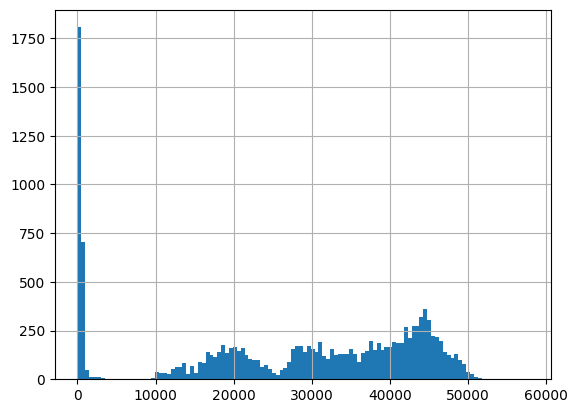

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True, errors='ignore')

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
2,590,uS/cm,NaN,590.0 microsiemens / centimeter
7,43.5,mS/cm,NaN,43500.0 microsiemens / centimeter
49,349,uS/cm,NaN,349.0 microsiemens / centimeter
52,49.7,mS/cm,NaN,49700.0 microsiemens / centimeter
58,8,count,NaN,NaN
...,...,...,...,...
496866,31.09,mS/cm,NaN,31090.0 microsiemens / centimeter
496890,16.051,mS/cm,NaN,16050.999999999998 microsiemens / centimeter
496910,32.504,mS/cm,NaN,32503.999999999996 microsiemens / centimeter
496918,31.989,mS/cm,NaN,31989.0 microsiemens / centimeter


##### Chlorophyll a

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ppb' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.004, 'milligram / liter')>
 <Quantity(0.0055, 'milligram / liter')>
 <Quantity(0.00948, 'milligram / liter')> ...
 <Quantity(0.0007, 'milligram / liter')>
 <Quantity(0.0011, 'milligram / liter')>
 <Quantity(0.0007, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    14012.000000
mean         0.176872
std          1.809121
min         -0.002400
25%          0.001800
50%          0.003500
75%          0.007282
max         92.900000
dtype: float64
Unusable results: 204
Usable results with inferred units: 9
Results outside threshold (0.0 to 11.031595436333586): 63


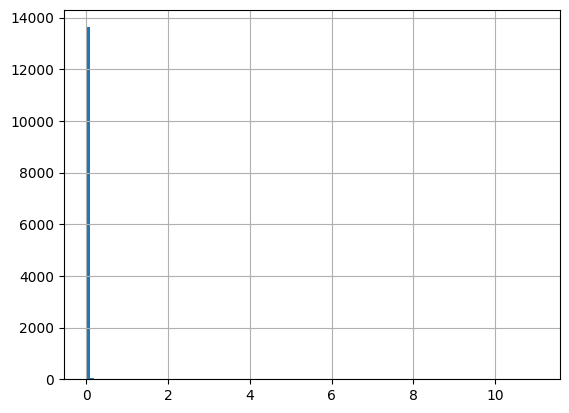

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
13,4.0,mg/m3,NaN,0.004000000000000001 milligram / liter
288,5.50,ug/L,NaN,0.0055 milligram / liter
393,9.48,ug/L,NaN,0.00948 milligram / liter
713,3.0,mg/m3,NaN,0.003000000000000001 milligram / liter
1013,NaN,mg/m3,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
569268,0.5,ug/l,NaN,0.0005 milligram / liter
569275,2.5,ug/l,NaN,0.0025 milligram / liter
569288,0.7,ug/l,NaN,0.0007 milligram / liter
569321,1.1,ug/l,NaN,0.0011 milligram / liter


##### Organic Carbon

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'umol/L * H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(7.05, 'milligram / liter')>
 <Quantity(7.57, 'milligram / liter')>
 <Quantity(3.5, 'milligram / liter')> ...
 <Quantity(4.1, 'milligram / liter')>
 <Quantity(7.79, 'milligram / liter')>
 <Quantity(5.79, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count      6185.000000
mean       5249.705328
std       35468.260584
min      -90000.000000
25%           1.790000
50%           4.900000
75%           8.900000
max      530000.000000
dtype: float64
Unusable results: 89
Usable results with inferred units: 0
Results outside threshold (0.0 to 218059.26883440206): 40


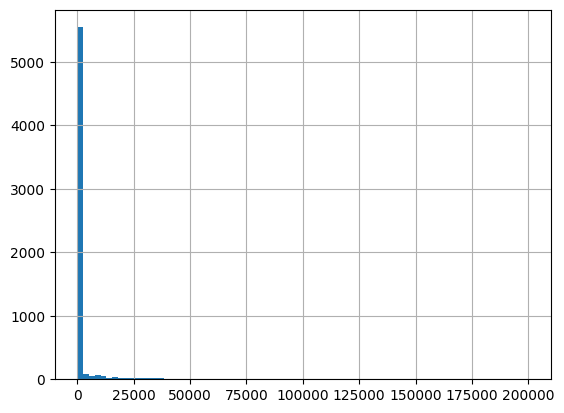

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True, errors='ignore')

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
1007,7.05,mg/L,NaN,7.05 milligram / liter
1145,7.57,mg/L,NaN,7.57 milligram / liter
1199,3.5,mg/L,NaN,3.5 milligram / liter
3158,3.8,mg/L,NaN,3.8 milligram / liter
4020,3.7,mg/L,NaN,3.7 milligram / liter
...,...,...,...,...
569457,5.9,mg/L,NaN,5.9 milligram / liter
569515,5.96,mg/l,NaN,5.96 milligram / liter
569558,4.1,mg/l,NaN,4.1 milligram / liter
569564,7.79,mg/l,NaN,7.79 milligram / liter


##### Turbidity (NTU)

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/harmonize.py:149: UserWarning: Bad Turbidity unit: count
  warn(f"Bad Turbidity unit: {unit}")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(7.6, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.0, 'Nephelometric_Turbidity_Units')>
 <Quantity(4.2, 'Nephelometric_Turbidity_Units')> ...
 <Quantity(2.1, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.9, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.7, 'Nephelometric_Turbidity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    34461.000000
mean        15.657555
std         72.069369
min       -999.000000
25%          1.250000
50%          2.500000
75%          5.770000
max       4100.000000
dtype: float64
Unusable results: 3137
Usable results with inferred units: 275
Results outside threshold (0.0 to 448.07376883334996): 215


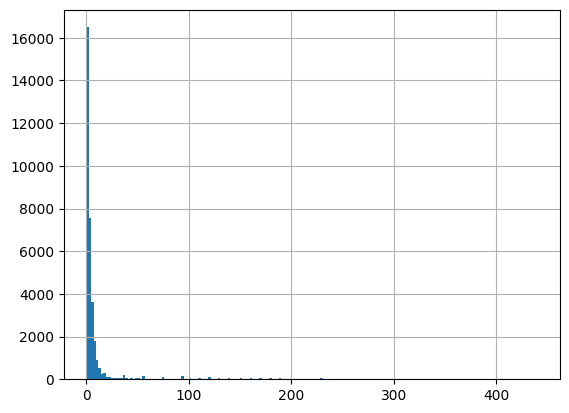

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
0,7.6,NTU,NaN,7.6 Nephelometric_Turbidity_Units
4,1,NTU,NaN,1.0 Nephelometric_Turbidity_Units
11,4.2,NTU,NaN,4.2 Nephelometric_Turbidity_Units
16,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
21,5.2,NTU,NaN,5.2 Nephelometric_Turbidity_Units
...,...,...,...,...
569619,1.6,NTRU,NaN,1.6 Nephelometric_Turbidity_Units
569629,5.8,NTRU,NaN,5.8 Nephelometric_Turbidity_Units
569633,2.1,NTRU,NaN,2.1 Nephelometric_Turbidity_Units
569637,2.9,NTRU,NaN,2.9 Nephelometric_Turbidity_Units


##### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False, errors='ignore')

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'g / H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:134: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return pandas.concat(lst_series).sort_index()


In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
517638,0.012,g,NaN,NaN
517639,0.0037,g,NaN,NaN
517640,0.0048,g,NaN,NaN
517641,0.001,g,NaN,NaN
517642,0.0088,g,NaN,NaN
...,...,...,...,...
568649,0.0051,g,NaN,NaN
568723,0.0025,g,NaN,NaN
568795,0.002,g,NaN,NaN
568834,0.0023,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus', errors='ignore')

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/pandas/core/construction.py:627: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/pandas/core/construction.py:627: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/pandas/core/construction.py:627: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'umol/L * H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.049, 'milligram / liter')>
 <Quantity(0.024, 'milligram / liter')>
 <Quantity(0.05, 'milligram / liter')> ...
 <Quantity(0.008, 'milligram / liter')>
 <Quantity(0.047, 'milligram / liter')>
 <Quantity(0.028, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
65,0.049,mg/L,NaN,NaN
67,0.024,mg/L,NaN,NaN
72,0.05,mg/L,NaN,NaN
89,0.027,mg/L,NaN,NaN
110,0.059712,mg/L,NaN,NaN
...,...,...,...,...
568856,0.006,mg/l as P,NaN,0.006 milligram / liter
568868,0.016,mg/l as P,NaN,NaN
568869,0.008,mg/l as P,NaN,0.008 milligram / liter
568876,0.047,mg/l as P,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
65,0.049,mg/L,NaN,NaN
67,0.024,mg/L,NaN,NaN
72,0.05,mg/L,NaN,NaN
89,0.027,mg/L,NaN,NaN
110,0.059712,mg/L,NaN,NaN
...,...,...,...,...
568830,0.036,mg/l as P,NaN,NaN
568841,0.021,mg/l as P,NaN,NaN
568855,0.011,mg/l as P,NaN,NaN
568868,0.016,mg/l as P,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
38508,0.023,ppm,NaN,0.023000000000000003 milligram / liter
43730,0.035,ppm,NaN,0.03500000000000001 milligram / liter
46336,0.017,ppm,NaN,0.017000000000000005 milligram / liter
46492,0.015,ppm,NaN,0.015000000000000003 milligram / liter
48282,0.015,ppm,NaN,0.015000000000000003 milligram / liter
...,...,...,...,...
568831,0.015,mg/l as P,NaN,0.015 milligram / liter
568842,0.005,mg/l as P,NaN,0.005 milligram / liter
568856,0.006,mg/l as P,NaN,0.006 milligram / liter
568869,0.008,mg/l as P,NaN,0.008 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
55180,0.03525375,mg/L,NaN,NaN
55247,0.107028125,mg/L,NaN,NaN
55757,0.0697675,mg/L,NaN,NaN
56022,0.04356,mg/L,NaN,NaN
56151,0.03654875,mg/L,NaN,NaN
...,...,...,...,...
553465,2600.0,mg/kg,NaN,NaN
553503,2900.0,mg/kg,NaN,NaN
553570,2500.0,mg/kg,NaN,NaN
553648,2600.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... <Quantity(140.0, 'Colony_Forming_Units / milliliter')>
 nan <Quantity(1.0, 'Colony_Forming_Units / milliliter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count      2462.000000
mean        910.512591
std        6103.365912
min           0.000000
25%          24.000000
50%          93.000000
75%         400.000000
max      250000.000000
dtype: float64
Unusable results: 5762
Usable results with inferred units: 1
Results outside threshold (0.0 to 37530.708061087345): 7


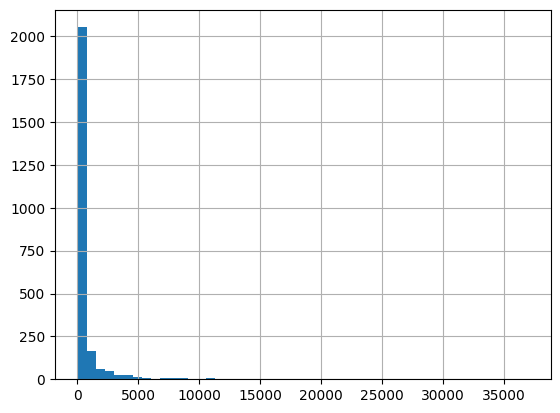

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
22182,40,#/100mL,NaN,NaN
22238,9,#/100mL,NaN,NaN
22257,20,#/100mL,NaN,NaN
22477,200,#/100mL,NaN,NaN
22705,NO DATA,#/100mL,"ResultMeasureValue: ""NO DATA"" result cannot be...",NaN
...,...,...,...,...
565465,450.0,cfu/100ml,NaN,450.0 Colony_Forming_Units / milliliter
565486,140.0,cfu/100ml,NaN,140.0 Colony_Forming_Units / milliliter
566072,180.0,#/100mL,NaN,NaN
566129,1.0,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'CFUcol/100mL' UNDEFINED UNIT for E_coli
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: '%' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.25/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... <Quantity(44.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(14.0, 'Colony_Forming_Units / milliliter')>
 <Quantity(390.0, 'Colony_Forming_Units / milliliter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count     5190.000000
mean       245.858339
std       1752.146999
min          0.000000
25%          0.500000
50%         30.000000
75%        127.750000
max      72000.000000
dtype: float64
Unusable results: 26846
Usable results with inferred units: 0
Results outside threshold (0.0 to 10758.740332329791): 14


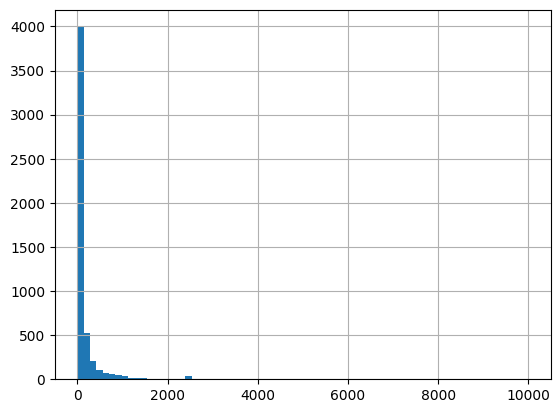

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
15,96,MPN/100mL,NaN,NaN
18,58,#/100mL,NaN,NaN
24,NaN,MPN/100mL,ResultMeasureValue: missing (NaN) result,NaN
37,24200,MPN/100mL,NaN,NaN
38,7270,MPN/100mL,NaN,NaN
...,...,...,...,...
569615,7.0,MPN/100 ml,NaN,7.0 Colony_Forming_Units / milliliter
569628,870.0,MPN/100 ml,NaN,870.0 Colony_Forming_Units / milliliter
569632,44.0,MPN/100 ml,NaN,44.0 Colony_Forming_Units / milliliter
569636,14.0,MPN/100 ml,NaN,14.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -30.0 to 4003.4828342857154
Results: 59993 
Mean: 23.31497447787275 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[4003.4828342857154]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
30987,804,ppth,NaN,804.0 Practical_Salinity_Units
245431,70.62,ppth,NaN,70.62 Practical_Salinity_Units
245931,71.49,ppth,NaN,71.49 Practical_Salinity_Units
270683,77.6666666666667,ppt,NaN,77.6666666666667 Practical_Salinity_Units
559728,4980.0,mg/mL @25C,ResultTemperatureBasisText: updated from 25 de...,4003.4828342857154 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [78]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
14084,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
15918,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
17732,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
25879,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
26522,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
473094,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
473140,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
473152,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
490515,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore conductivity results:

In [79]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

2                      590.0 microsiemens / centimeter
7                    43500.0 microsiemens / centimeter
49                     349.0 microsiemens / centimeter
52                   49700.0 microsiemens / centimeter
85                     443.0 microsiemens / centimeter
                              ...                     
496866               31090.0 microsiemens / centimeter
496890    16050.999999999998 microsiemens / centimeter
496910    32503.999999999996 microsiemens / centimeter
496918               31989.0 microsiemens / centimeter
496924               16107.0 microsiemens / centimeter
Name: Conductivity, Length: 13491, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [80]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
279986,57700,uS/cm,NaN,NaN,57700.0 microsiemens / centimeter
318612,52.418,mS/cm,NaN,NaN,52418.0 microsiemens / centimeter
300871,52.418,mS/cm,NaN,NaN,52418.0 microsiemens / centimeter
315667,51.618,mS/cm,NaN,NaN,51618.0 microsiemens / centimeter
308895,51.618,mS/cm,NaN,NaN,51618.0 microsiemens / centimeter
...,...,...,...,...,...
3464,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
8440,0,uS/cm,NaN,NaN,0.0 microsiemens / centimeter
97054,0,mS/cm,NaN,NaN,0.0 microsiemens / centimeter
97206,0,mS/cm,NaN,NaN,0.0 microsiemens / centimeter


In [81]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

279986    38.468 dimensionless
318612    34.521 dimensionless
300871    34.521 dimensionless
315667    33.929 dimensionless
308895    33.929 dimensionless
                  ...         
3464       0.012 dimensionless
8440       0.012 dimensionless
97054      0.012 dimensionless
97206      0.012 dimensionless
3992       0.012 dimensionless
Name: Salinity, Length: 13491, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [82]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
279986,2021-06-21,NaN,NaN
318612,2022-08-09,12:58:00,EST
300871,2022-08-09,12:58:00,EST
315667,2022-08-09,13:25:00,EST
308895,2022-08-09,13:25:00,EST
...,...,...,...
569749,1956-08-16,NaN,NaN
569750,1956-06-16,NaN,NaN
569751,1956-07-01,NaN,NaN
569752,1955-08-16,NaN,NaN


In [83]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

,ActivityStartDate,Activity_datetime
279986,2021-06-21,NaT
318612,2022-08-09,2022-08-09 17:58:00+00:00
300871,2022-08-09,2022-08-09 17:58:00+00:00
315667,2022-08-09,2022-08-09 18:25:00+00:00
308895,2022-08-09,2022-08-09 18:25:00+00:00
...,...,...
569749,1956-08-16,NaT
569750,1956-06-16,NaT
569751,1956-07-01,NaT
569752,1955-08-16,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [84]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

223201    0.15
225337    0.15
118227    0.15
123436    0.15
223870    0.15
          ... 
448481    0.15
448483    0.15
448484    0.15
448485    1.23
448486    1.65
Name: ResultDepthHeightMeasure/MeasureValue, Length: 24059, dtype: float64

#### Characteristic to Column (long to wide format)

In [85]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_DO,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Temperature,QA_Conductivity,QA_Chlorophyll,QA_Sediment,QA_Turbidity,QA_Salinity
279986,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-185450_2021,2021-06-21,NaN,NaN,NARS_WQX-NWC_RI-10033,STORET-1040684142,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318612,AQUINNAH_WQX,Wampanoag Tribe of Gay Head (Aquinnah) (Tribal),AQUINNAH_WQX-P3:202208091258:FM,2022-08-09,12:58:00,EST,AQUINNAH_WQX-P3,STORET-1057585495,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300871,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220809125800:FM:B,2022-08-09,12:58:00,EST,WTGHA-P3,STORET-1041330082,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315667,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P4:20220809132500:FM:B,2022-08-09,13:25:00,EST,WTGHA-P4,STORET-1041330098,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308895,AQUINNAH_WQX,Wampanoag Tribe of Gay Head (Aquinnah) (Tribal),AQUINNAH_WQX-P4:202208091325:FM,2022-08-09,13:25:00,EST,AQUINNAH_WQX-P4,STORET-1057585502,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569748,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_DUCK_W_19570701_731710,1957-07-01,NaN,NaN,11NPSWRD_WQX-CACO_DUCK_W,STORET-740598867,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569749,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_DUCK_W_19560816_731708,1956-08-16,NaN,NaN,11NPSWRD_WQX-CACO_DUCK_W,STORET-740598866,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569750,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_DUCK_W_19560616_731704,1956-06-16,NaN,NaN,11NPSWRD_WQX-CACO_DUCK_W,STORET-740598862,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569751,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_DUCK_W_19560701_731705,1956-07-01,NaN,NaN,11NPSWRD_WQX-CACO_DUCK_W,STORET-740598863,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [87]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

53433 fewer rows


In [88]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [89]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [90]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Carbon', 'QA_pH', 'QA_E_coli',
       'QA_Nitrogen', 'QA_Fecal_Coliform', 'QA_Secchi', 'QA_DO',
       'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Temperature', 'QA_Conductivity', 'QA_Chlorophyll', 'QA_Sediment',
       'QA_Turbidity', 'QA_Salinity'],
      dtype='object')

In [91]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_DO,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Temperature,QA_Conductivity,QA_Chlorophyll,QA_Sediment,QA_Turbidity,QA_Salinity
279986,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-185450_2021,NARS_WQX-NWC_RI-10033,STORET,NaN,NaN,NaN,NaN,38.468 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318612,AQUINNAH_WQX,Wampanoag Tribe of Gay Head (Aquinnah) (Tribal),AQUINNAH_WQX-P3:202208091258:FM,AQUINNAH_WQX-P3,STORET,NaN,NaN,NaN,NaN,34.521 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300871,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220809125800:FM:B,WTGHA-P3,STORET,NaN,NaN,NaN,NaN,34.521 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315667,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P4:20220809132500:FM:B,WTGHA-P4,STORET,NaN,NaN,NaN,NaN,33.929 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308895,AQUINNAH_WQX,Wampanoag Tribe of Gay Head (Aquinnah) (Tribal),AQUINNAH_WQX-P4:202208091325:FM,AQUINNAH_WQX-P4,STORET,NaN,NaN,NaN,NaN,33.929 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Carbon',
 'QA_DO',
 'QA_TDP_Phosphorus',
 'QA_Conductivity',
 'QA_Sediment']

<Axes: >

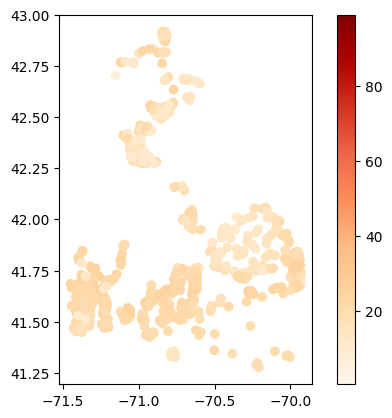

In [93]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)